In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.feature_selection as fs
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import numpy as np

with open('task_2_annotations_82d1d6d1093eaab6_e330cbf_pandas.pkl', 'rb') as f:
    annotations = pickle.load(f)
    
with open('task_2_features_1d8b658c21ddc127_e330cbf_pandas.pkl', 'rb') as f:
    features = pickle.load(f)
    
# print(annotations.shape)

# Plot segments 

<b>Pentagon</b> - mean value over all annotations of a segment  <br> 

<b>Lines</b> - quadrant borders  <br> 

<b>Radius</b> of a datapoint corresponds to its populatiry
   (i.e. the bigger the point the more annotators classified it the same)  <br> 

The annotations dataset <b>lacks 2 values</b>:
1) pianist_id = 3; segment_id = 1; annotator_id = 90; <b>gems_peacefulness</b> is missing <br>
2) pianist_id = 10; segment_id = 24; annotator_id = 80; <b>gemmes_interior</b> is missing

In [2]:
def draw_segment_analytics(idx, annotaions):
    seg_annotations = annotations.loc[(annotations["segment_id"] == idx),["arousal", "valence"]]

    arousal_mean, valence_mean = seg_annotations.mean(axis=0).array

    seg_annotations = seg_annotations.groupby(['arousal', 'valence']).size().reset_index().rename(columns={0:'count'})
    arousal = seg_annotations['arousal'].array
    valence = seg_annotations['valence'].array
    pnt_size = seg_annotations['count'].array ** 2

    plt.scatter(arousal, valence, s=pnt_size)
    plt.scatter(arousal_mean, valence_mean, s = max(pnt_size) * 2, marker = 'p')
    plt.axhline(0, color = 'r')
    plt.axvline(3, color='r')
    plt.title("Segment_id = {}".format(idx))
    plt.xlabel("Arousal")
    plt.ylabel("Valence")
    plt.xlim(1, 5)
    plt.ylim(-2, 2)

    plt.show()

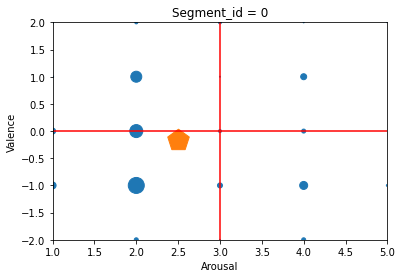

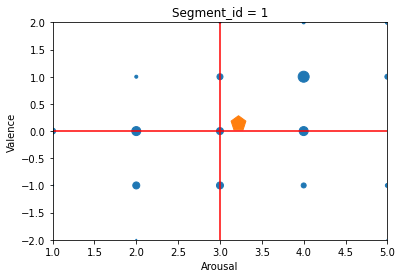

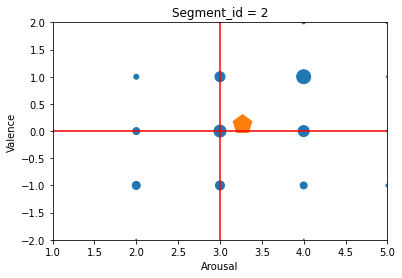

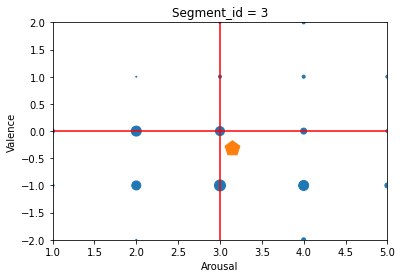

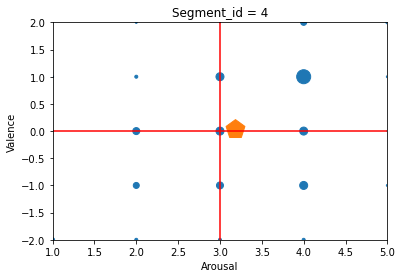

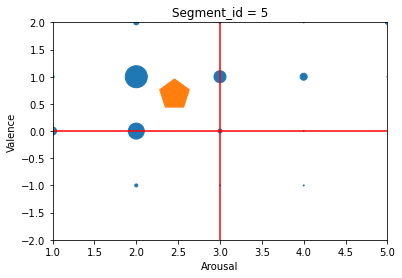

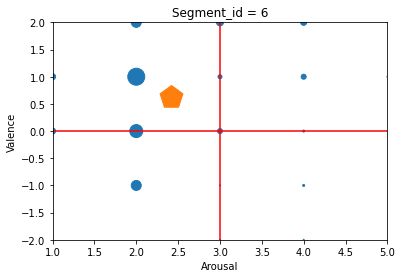

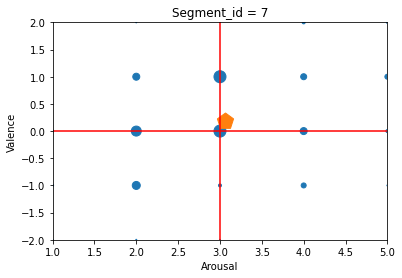

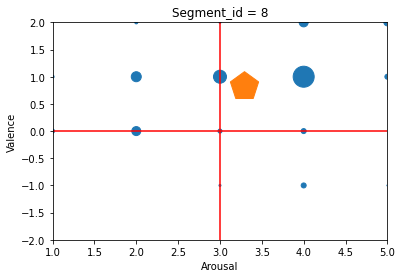

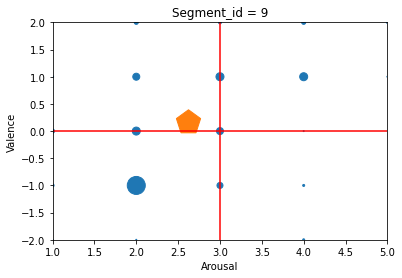

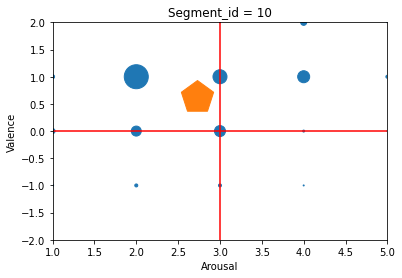

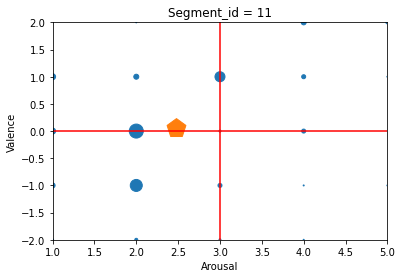

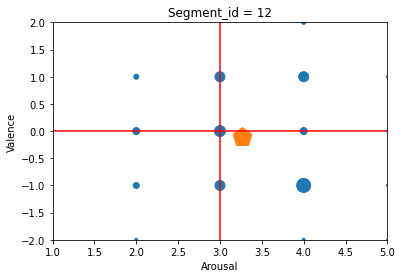

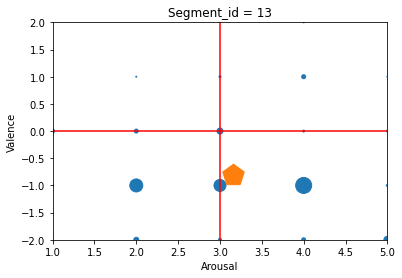

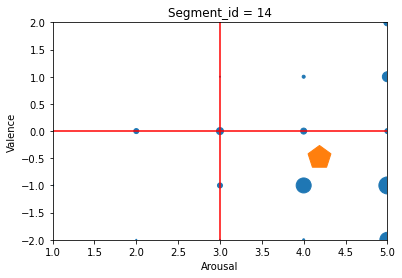

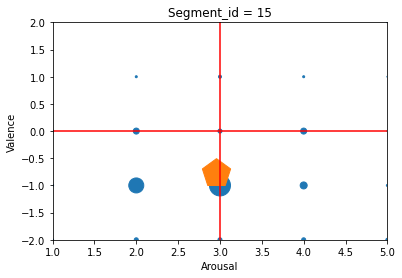

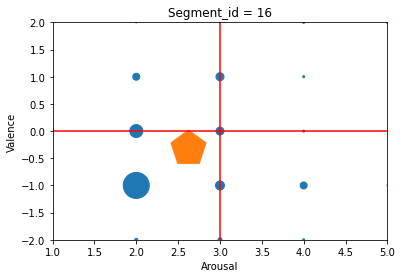

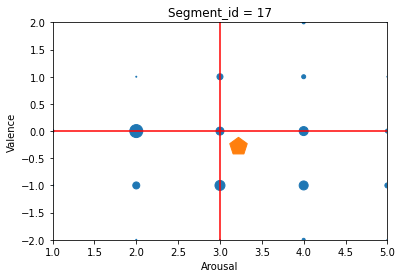

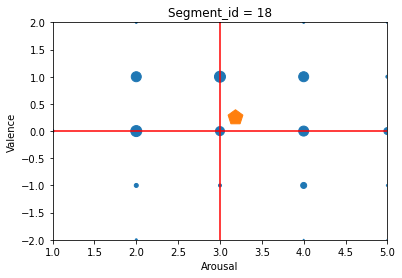

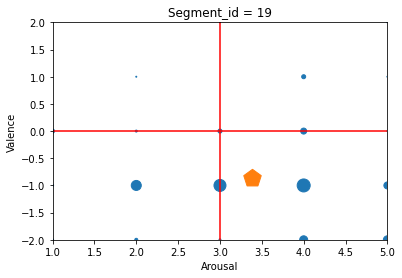

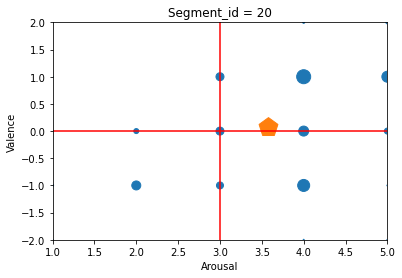

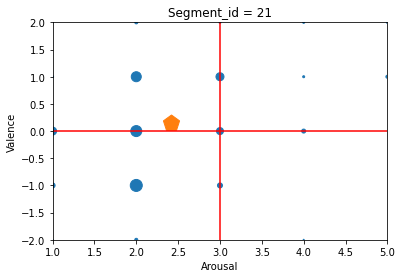

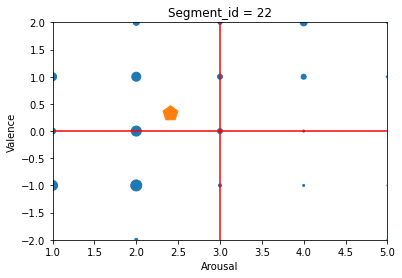

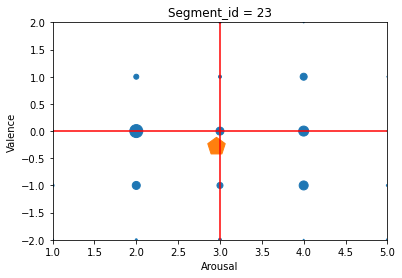

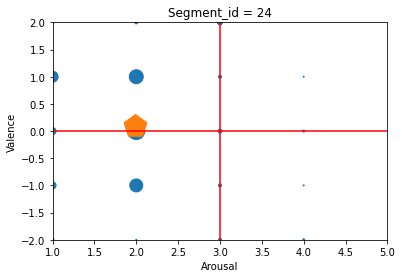

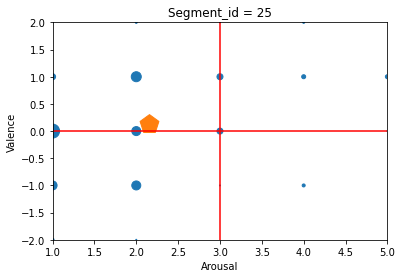

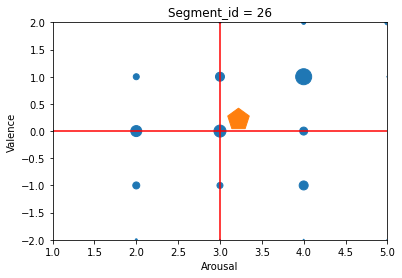

In [3]:
seg_num = annotations["segment_id"].nunique(1)
for idx in range(seg_num):
    draw_segment_analytics(idx, annotations)

# Remove rows with missing values

In [4]:
print(annotations[annotations.isnull().any(axis=1)].index)
annotations.drop(index=annotations[annotations.isnull().any(axis=1)].index, inplace=True)
print(annotations[annotations.isnull().any(axis=1)].index)

Int64Index([5115, 2957], dtype='int64')
Int64Index([], dtype='int64')


# Selection of the most valuable features 

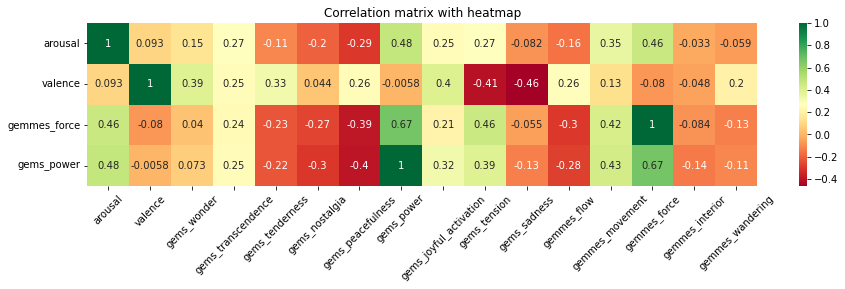

In [5]:
# Correlation btw A/V and annotations
# Center the data // doesn't matter for correlation 
centered_ann = annotations.loc[:, 'arousal':]
centered_ann = centered_ann.subtract(centered_ann.mean())

f = plt.figure(figsize=(15,3))
ax = f.add_subplot()
sns.heatmap(centered_ann.corr().loc[['arousal', 'valence', 'gemmes_force', 'gems_power'], :],annot=True,cmap="RdYlGn", ax = ax)
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.title("Correlation matrix with heatmap")
plt.show()

# The most correlated features are 
# arousal: gems_power(0.475225) and gemmes_force(0.462607)
# valence: gems_wonder(0.393563) and gems_joyful_activation(0.399462)
# valance decorrelation: gems_sadness(-0.463651) and gems_tension(-0.407697)

In [6]:
# Univariate feature selection
score_funcs = [fs.chi2, fs.f_classif, fs.mutual_info_classif]
all_features = annotations.loc[:, 'gems_wonder':]
arousal = annotations.loc[:, ['arousal']]
valence = annotations.loc[:, ['valence']]
labels = [arousal, valence] 
most_important_f = dict()
for label in labels:
    most_important_f[list(label.columns)[0]] = set()
    for func in score_funcs:
        bestfeatures = fs.SelectKBest(score_func=func, k=10)
        
        fit = bestfeatures.fit(all_features, np.ravel(label.to_numpy(dtype='float64')))
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(all_features.columns)
        featureScores = pd.concat([dfcolumns,dfscores],axis=1)
        featureScores.columns = ['Specs','Score'] 
        print("The most important features wrt {}".format(list(label.columns)[0]))
        print(featureScores.nlargest(6,'Score'))
        print()
        
        if len(most_important_f[list(label.columns)[0]]) != 0:
            most_important_f[list(label.columns)[0]] = most_important_f[list(label.columns)[0]].intersection(set(featureScores.nlargest(6,'Score')['Specs']))
        else:
            most_important_f[list(label.columns)[0]] = set(featureScores.nlargest(6,'Score')['Specs'])
#     print(np.unique(most_important_f[list(label.columns)[0]]))

print("==========================")

print("Features that worth considaration")
for key in list(most_important_f.keys()):
    print("For {}".format(key))
    for feature in most_important_f[key]:
        print("* {}".format(feature))
    print()

The most important features wrt arousal
                 Specs       Score
5           gems_power  403.596518
11        gemmes_force  382.280164
10     gemmes_movement  205.727021
4    gems_peacefulness  179.995400
7         gems_tension  146.963138
1   gems_transcendence  113.530521

The most important features wrt arousal
                 Specs       Score
5           gems_power  200.237213
11        gemmes_force  186.643899
10     gemmes_movement   94.628708
4    gems_peacefulness   63.025200
1   gems_transcendence   53.663411
7         gems_tension   51.482106

The most important features wrt arousal
                     Specs     Score
11            gemmes_force  0.133021
5               gems_power  0.119703
10         gemmes_movement  0.090559
6   gems_joyful_activation  0.057120
4        gems_peacefulness  0.038222
0              gems_wonder  0.037868

The most important features wrt valence
                    Specs       Score
8            gems_sadness  427.175338
7           

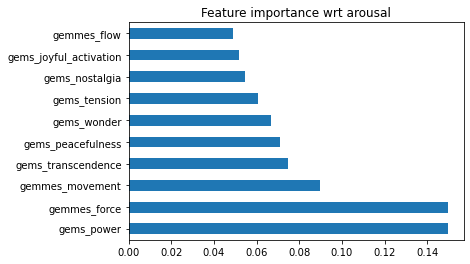

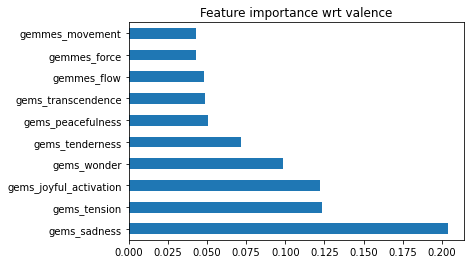

In [7]:
# Tree-based feature selection

for label in labels:
    model = RandomForestClassifier(min_samples_leaf=10, n_estimators=100)
    model.fit(all_features, np.ravel(label.to_numpy(dtype='float64')))
    feat_importances = pd.Series(model.feature_importances_, index=all_features.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title("Feature importance wrt {}".format(list(label.columns)[0]))
    plt.show()